In [75]:
import pandas as pd

dataset=pd.read_csv("data/AEP_hourly.csv")
dataset.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [76]:
dataset.shape

(121273, 2)

In [77]:
sample_data=dataset.sample(frac=0.2,random_state=42)
sample_data.shape

(24255, 2)

Text(0.5, 1.0, 'Distribution of AEP_MW')

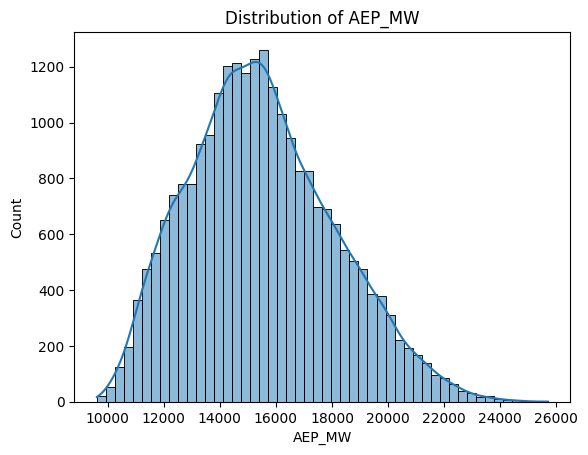

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(sample_data['AEP_MW'], bins=50, kde=True)
plt.title('Distribution of AEP_MW')

In [79]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# DO NOT fit scaler on entire dataset - will cause data leakage
# We'll fit it on training data only after the split
scaler = MinMaxScaler()

dataset["AEP_MW_scaled"] = scaler.fit_transform(dataset['AEP_MW'].values.reshape(-1, 1))


In [80]:
# Feature engineering: add lag features BEFORE dropping NaN
dataset['AEP_MW_lag_1'] = dataset['AEP_MW_scaled'].shift(1)
dataset['AEP_MW_lag_2'] = dataset['AEP_MW_scaled'].shift(2)
dataset['AEP_MW_lag_24'] = dataset['AEP_MW_scaled'].shift(24)  # Previous day same hour



In [81]:
dataset.head()

,Datetime,AEP_MW,AEP_MW_scaled,AEP_MW_lag_1,AEP_MW_lag_2,AEP_MW_lag_24
0,2004-12-31 01:00:00,13478.0,0.241839,NaN,NaN,NaN
1,2004-12-31 02:00:00,12865.0,0.203798,0.241839,NaN,NaN
2,2004-12-31 03:00:00,12577.0,0.185925,0.203798,0.241839,NaN
3,2004-12-31 04:00:00,12517.0,0.182202,0.185925,0.203798,NaN
4,2004-12-31 05:00:00,12670.0,0.191697,0.182202,0.185925,NaN


In [82]:
dataset.dropna(inplace=True)

In [83]:
dataset['Datetime'] = pd.to_datetime(dataset['Datetime'])

# Extract components of the Datetime column
dataset['Year'] = dataset['Datetime'].dt.year
dataset['Month'] = dataset['Datetime'].dt.month
dataset['Day'] = dataset['Datetime'].dt.day
dataset['Hour'] = dataset['Datetime'].dt.hour

In [84]:
# Add cyclic encoding for temporal features
# This treats periodic features (Month, Hour, Day) as circular

# Month: Cyclical encoding (12 months in a year)
dataset['Month_sin'] = np.sin(2 * np.pi * dataset['Month'] / 12)
dataset['Month_cos'] = np.cos(2 * np.pi * dataset['Month'] / 12)

# Hour: Cyclical encoding (24 hours in a day)
dataset['Hour_sin'] = np.sin(2 * np.pi * dataset['Hour'] / 24)
dataset['Hour_cos'] = np.cos(2 * np.pi * dataset['Hour'] / 24)

# Day of week from Datetime
dataset['DayOfWeek'] = dataset['Datetime'].dt.dayofweek
dataset['DayOfWeek_sin'] = np.sin(2 * np.pi * dataset['DayOfWeek'] / 7)
dataset['DayOfWeek_cos'] = np.cos(2 * np.pi * dataset['DayOfWeek'] / 7)

print("Cyclic features added successfully")
print(dataset[['Month', 'Month_sin', 'Month_cos', 'Hour', 'Hour_sin', 'Hour_cos']].head())


Cyclic features added successfully
    Month     Month_sin  Month_cos  Hour  Hour_sin  Hour_cos
24     12 -2.449294e-16        1.0     1  0.258819  0.965926
25     12 -2.449294e-16        1.0     2  0.500000  0.866025
26     12 -2.449294e-16        1.0     3  0.707107  0.707107
27     12 -2.449294e-16        1.0     4  0.866025  0.500000
28     12 -2.449294e-16        1.0     5  0.965926  0.258819


In [85]:
feature_columns = [
    'Month_sin', 'Month_cos',           # Cyclic month
    'Hour_sin', 'Hour_cos',             # Cyclic hour
    'DayOfWeek_sin', 'DayOfWeek_cos',   # Cyclic day of week
    'AEP_MW_lag_1', 'AEP_MW_lag_2',     # Recent lags
    'AEP_MW_lag_24'                     # Previous day same hour (seasonality)
]

# Drop rows with NaN in any feature column
dataset_clean = dataset[feature_columns + ['AEP_MW_scaled']].dropna()

X = dataset_clean[feature_columns].values
y = dataset_clean['AEP_MW_scaled'].values


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")


feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)  # Use training stats for test

Train set: X_train=(96999, 9), y_train=(96999,)
Test set: X_test=(24250, 9), y_test=(24250,)


In [87]:
import torch 

# Use the properly scaled data
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [88]:
import torch.nn as nn

class EnergyConsumptionModel(nn.Module):
    def __init__(self, input_size):
        super(EnergyConsumptionModel, self).__init__()
        # Input -> Hidden layers with batch norm and dropout
        self.fc1 = nn.Linear(input_size, 128)      # Increased hidden layer
        self.bn1 = nn.BatchNorm1d(128)             # Batch normalization
        self.dropout1 = nn.Dropout(0.3)            # Dropout 30%
        
        self.fc2 = nn.Linear(128, 64)              # Second hidden layer
        self.bn2 = nn.BatchNorm1d(64)              
        self.dropout2 = nn.Dropout(0.2)            # Dropout 20%
        
        self.fc3 = nn.Linear(64, 32)               # Third hidden layer
        self.fc4 = nn.Linear(32, 1)                # Output layer (regression)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = torch.relu(x)
        
        x = self.fc4(x)  # No activation for regression
        return x


In [89]:
input_size = X_train.shape[1]  # Number of features
model = EnergyConsumptionModel(input_size)

In [90]:
from torch import optim

criterion = nn.MSELoss()
# Use a better optimizer with learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [ ]:
from tqdm import tqdm
epochs = 200

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    
    y_train_pred = model(X_train_tensor)
    train_loss = criterion(y_train_pred, y_train_tensor)
    
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_test_tensor)
        val_loss = criterion(y_val_pred, y_test_tensor)
    val_losses.append(val_loss.item())
    
    scheduler.step(val_loss)
    
    # Print progress
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss.item():.6f} | Val Loss: {val_loss.item():.6f}')


 10%|█         | 20/200 [00:07<01:02,  2.87it/s]

Epoch [20/200] | Train Loss: 0.009854 | Val Loss: 0.029178


 20%|██        | 40/200 [00:15<01:31,  1.75it/s]

Epoch [40/200] | Train Loss: 0.007065 | Val Loss: 0.005455


 30%|███       | 60/200 [00:27<01:17,  1.82it/s]

Epoch [60/200] | Train Loss: 0.005561 | Val Loss: 0.003604


 40%|████      | 80/200 [00:38<01:04,  1.86it/s]

Epoch [80/200] | Train Loss: 0.004797 | Val Loss: 0.002890


 50%|█████     | 100/200 [00:48<00:52,  1.89it/s]

Epoch [100/200] | Train Loss: 0.004531 | Val Loss: 0.002434


 60%|██████    | 120/200 [00:59<00:41,  1.93it/s]

Epoch [120/200] | Train Loss: 0.004230 | Val Loss: 0.002338


 70%|███████   | 140/200 [01:10<00:32,  1.83it/s]

Epoch [140/200] | Train Loss: 0.004054 | Val Loss: 0.002256


 80%|████████  | 160/200 [01:21<00:20,  1.92it/s]

Epoch [160/200] | Train Loss: 0.003789 | Val Loss: 0.002187


 90%|█████████ | 180/200 [01:31<00:10,  1.89it/s]

Epoch [180/200] | Train Loss: 0.003602 | Val Loss: 0.002127


100%|██████████| 200/200 [01:42<00:00,  1.95it/s]

Epoch [200/200] | Train Loss: 0.003396 | Val Loss: 0.002066
✓ Training completed


In [92]:
model.eval()

# Make predictions on test set
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Convert to numpy
y_pred_test_np = y_pred_test.numpy()

y_pred_original = scaler.inverse_transform(y_pred_test_np)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"Predicted range: {y_pred_original.min():.2f} - {y_pred_original.max():.2f}")
print(f"Actual range: {y_test_original.min():.2f} - {y_test_original.max():.2f}")


Predicted range: 10387.77 - 22347.31
Actual range: 9581.00 - 24739.00


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate metrics on original scale
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100


print("\nSample predictions vs actual (first 20 samples):")
comparison = pd.DataFrame({
    'Actual': y_test_original[:20].flatten(),
    'Predicted': y_pred_original[:20].flatten(),
    'Error': np.abs(y_test_original[:20].flatten() - y_pred_original[:20].flatten()),
    'Error%': np.abs((y_test_original[:20].flatten() - y_pred_original[:20].flatten()) / y_test_original[:20].flatten()) * 100
})
print(comparison)


MODEL PERFORMANCE METRICS (Original Scale)
Mean Absolute Error (MAE):  583.02 MW
Root Mean Squared Error (RMSE): 732.47 MW
Mean Absolute Percentage Error (MAPE): 3.79%
R-Squared (R2): 0.9186

Sample predictions vs actual (first 20 samples):
     Actual     Predicted        Error     Error%
0   15317.0  14429.344727   887.655273   5.795229
1   14786.0  13941.943359   844.056641   5.708485
2   14391.0  13920.636719   470.363281   3.268454
3   14384.0  13980.291992   403.708008   2.806646
4   14479.0  13965.453125   513.546875   3.546839
5   15273.0  14033.142578  1239.857422   8.117969
6   15809.0  14494.719727  1314.280273   8.313494
7   15821.0  14963.676758   857.323242   5.418894
8   15624.0  14773.826172   850.173828   5.441461
9   15188.0  14392.432617   795.567383   5.238131
10  14652.0  13791.805664   860.194336   5.870832
11  18461.0  14717.143555  3743.856445  20.279814
12  18462.0  16137.604492  2324.395508  12.590161
13  18544.0  17969.826172   574.173828   3.096278
14  18793

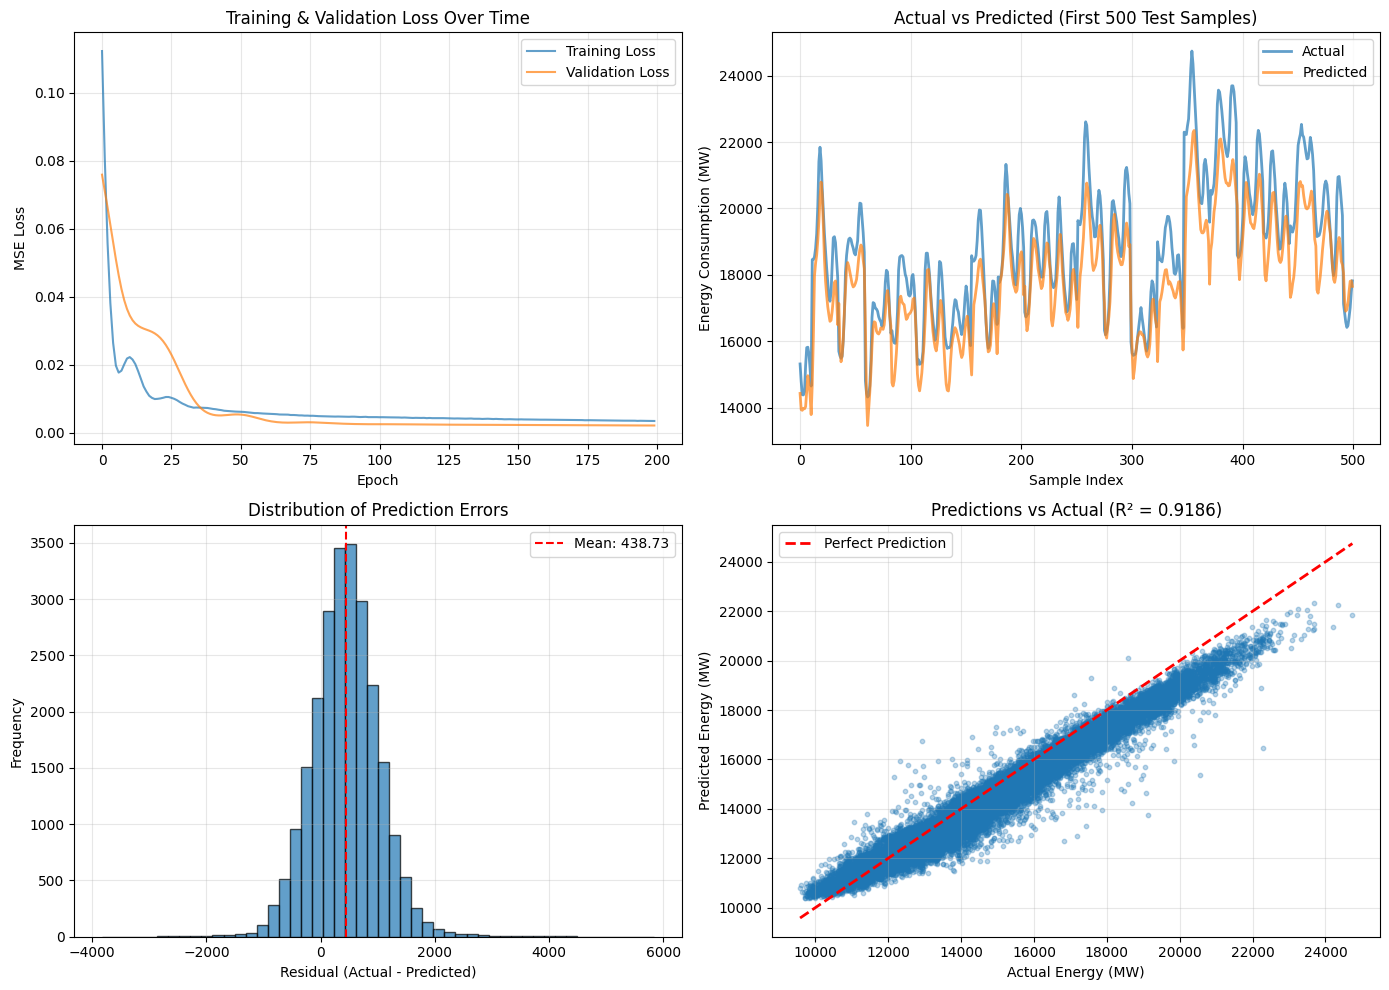


✓ Visualization complete!
Mean residual: 438.73 MW (should be ~0)
Std of residuals: 586.54 MW


In [ ]:
# Visualization: Training curves and predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Training Loss Curve
axes[0, 0].plot(train_losses, label='Training Loss', alpha=0.7)
axes[0, 0].plot(val_losses, label='Validation Loss', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE Loss')
axes[0, 0].set_title('Training & Validation Loss Over Time')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Actual vs Predicted (first 500 samples)
axes[0, 1].plot(y_test_original[:500], label='Actual', alpha=0.7, linewidth=2)
axes[0, 1].plot(y_pred_original[:500], label='Predicted', alpha=0.7, linewidth=2)
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Energy Consumption (MW)')
axes[0, 1].set_title('Actual vs Predicted (First 500 Test Samples)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals Distribution
residuals = y_test_original.flatten() - y_pred_original.flatten()
axes[1, 0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', label=f'Mean: {residuals.mean():.2f}')
axes[1, 0].set_xlabel('Residual (Actual - Predicted)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Scatter: Predicted vs Actual
axes[1, 1].scatter(y_test_original, y_pred_original, alpha=0.3, s=10)
# Add diagonal line (perfect prediction)
min_val = min(y_test_original.min(), y_pred_original.min())
max_val = max(y_test_original.max(), y_pred_original.max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Actual Energy (MW)')
axes[1, 1].set_ylabel('Predicted Energy (MW)')
axes[1, 1].set_title(f'Predictions vs Actual (R² = {r2:.4f})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
